In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
engine

Engine(sqlite:///hawaii.sqlite)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20528886190>,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01'}

In [11]:
# Find the most recent date in the data set.
recentDate = session.query(func.max(Measurement.date)).first()
print(recentDate[0])

2017-08-23


In [56]:
#Determine the date range


datetime.datetime(2016, 8, 23, 0, 0)

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
dateRange = dt.datetime.strptime(recentDate[0], '%Y-%m-%d') - dt.timedelta(days=365)
dateRange

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= dateRange).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rows, columns=['Date', 'Precipitation'])
df.loc[:,'Precipitation'] =  df['Precipitation'].fillna(0)
prcpDF = df.groupby('Date')['Precipitation'].mean() 

# Sort the dataframe by date
prcpDF.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.head()


Date
2016-08-19    0.476667
2016-08-20    0.060000
2016-08-21    0.402000
2016-08-22    0.751429
2016-08-23    0.387143
Name: Precipitation, dtype: float64

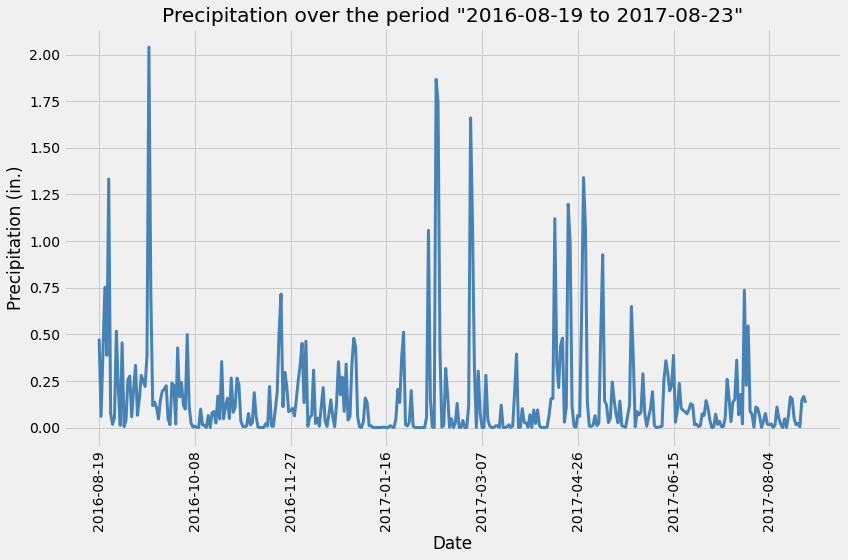

In [108]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (12, 8))
prcpDF.plot(ax = ax, x_compat = True, linewidth=3, color='steelblue')

ax.set_ylabel('Precipitation (in.)')
ax.set_title('Precipitation over the period "2016-08-19 to 2017-08-23"')
ax.fill()
plt.xticks(rotation="vertical")
#plt.savefig("Images/precipitation.png")

plt.tight_layout()
plt.show()

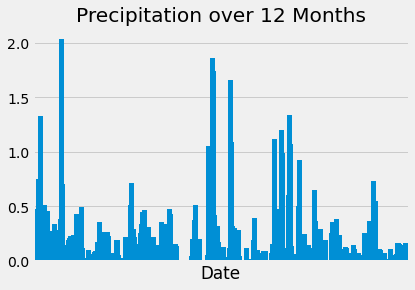

In [83]:
##########Need to fix this###############################

prcpDF.plot(kind='bar', width=5, title='Precipitation over 12 Months')

#prcpDF.plot(kind='bar', width=5, figsize=(12,8), x_compat=True)
#plt.title("Precipitation Last 12 Months")
#plt.ylabel("Precipitation (Inches)")
#plt.xlabel("Date")
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Aug 2016', 'Sep 2016', 'Oct 2016', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Apr 2017', 'May 2017', 'Jun 2017', 'Jul 2017'])
plt.xticks([])
plt.grid(True)
#plt.tight_layout()

plt.show()

TypeError: 'str' object is not callable

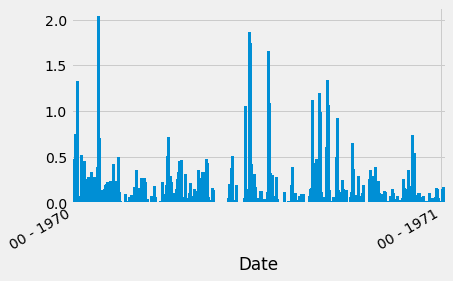

In [71]:
import matplotlib.dates as mdates
##########Need to fix this###############################
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%M - %Y')

fig, ax = plt.subplots()
#x.bar(x = prcpDF['Date'], data=prcpDF, width=2)
prcpDF.plot(kind='bar', width=3, ax = ax)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)
fig.autofmt_xdate()

#prcpDF.plot(kind='bar', width=5, figsize=(12,8), x_compat=True)
plt.title("Precipitation Last 12 Months")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Aug 2016', 'Sep 2016', 'Oct 2016', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Apr 2017', 'May 2017', 'Jun 2017', 'Jul 2017'])
#plt.xticks([])

plt.tight_layout()

plt.show()

In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

count    365.000000
mean       0.156103
std        0.275657
min        0.000000
25%        0.008571
50%        0.065000
75%        0.175714
max        2.040000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
station = session.query(func.count(Station.station))
stationCount = station[0][0]
print(f"Total number of stations = {stationCount}")

Total number of stations = 9


In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station))\
        .group_by(Measurement.station)\
        .order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .filter(Measurement.station == 'USC00519281').first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

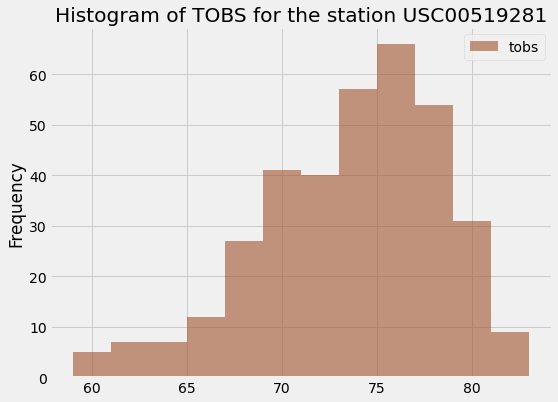

In [119]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recentDate = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').first()

dateRange = dt.datetime.strptime(recentDate[0], '%Y-%m-%d') - dt.timedelta(days=365)
dateRange

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= dateRange).all()
df = pd.DataFrame(rows)
df.plot(kind='hist',bins=12, title = 'Histogram of TOBS for the station USC00519281', xlabel = 'Temperature', figsize=(8,6), color='sienna', alpha=0.6)

plt.ylabel = 'Frequency'
#plt.xlabel = 'Temperature'
plt.show()


# Close session

In [89]:
# Close Session
session.close()